In [ ]:
import numpy as np
from qutip import *

# 1. Basis states and projectors definition
# Z basis: |0>, |1>
ket0 = basis(2, 0)
ket1 = basis(2, 1)

# X basis: |+> and |–> (normalized)
ket_plus  = (ket0 + ket1).unit()    # |+> = (|0>+|1>)/√2
ket_minus = (ket0 - ket1).unit()     # |–> = (|0>–|1>)/√2

# Here, X_i and Z_j are the projectors of the corresponding basis states.
#    Z0 = |0><0|, Z1 = |1><1|
#    X0 = |+><+|, X1 = |–><–|
Z0 = ket0 * ket0.dag()
Z1 = ket1 * ket1.dag()
X0 = ket_plus * ket_plus.dag()
X1 = ket_minus * ket_minus.dag()

# 2. GHZ state generation (Alice + n kings, total n+1 qubits)
def get_GHZ_state(n_kings, prep_basis="Z"):
    """
    n_kings: Number of kings (total qubits = n_kings + 1, including Alice)
    prep_basis: 'Z' or 'X'
      - 'Z' → GHZ state = (|0...0⟩ + |1...1⟩)/√2
      - 'X' → GHZ state = (|+...+⟩ + |–...–⟩)/√2
    Returns: Qobj (dimension 2^(n_kings+1))
    """
    n_total = n_kings + 1  # Alice + kings
    if prep_basis == "Z":
        state0 = tensor(*[ket0 for _ in range(n_total)])
        state1 = tensor(*[ket1 for _ in range(n_total)])
    elif prep_basis == "X":
        state0 = tensor(*[ket_plus for _ in range(n_total)])
        state1 = tensor(*[ket_minus for _ in range(n_total)])
    else:
        raise ValueError("prep_basis must be 'Z' or 'X'.")
    ghz = (state0 + state1).unit()
    return ghz

# 3. Simulating measurement results of the kings (randomly generated)
def simulate_kings_measurement(n_kings):
    """
    Randomly generates (s, t) tuples for each king.
      s: 0 or 1 (e.g., Z measurement result; basis information)
      t: 0 or 1 (e.g., X measurement result; used as key bits)
    Returns: [(s1, t1), (s2, t2), ..., (s_n, t_n)]
    """
    outcomes = []
    for _ in range(n_kings):
        s = np.random.choice([0, 1])
        t = np.random.choice([0, 1])
        outcomes.append((s, t))
    return outcomes

# 4. Extracting eigenstates from a "measurement operator" for a single king
#    - When the preparation basis is Z: Eₖ^Z = Zₛ * Xₜ  
#      (where Zₛ = |s⟩⟨s|, Xₜ = |(+)/(|–)⟩⟨(+)/(|–)| )
#    - When the preparation basis is X: Eₖ^X = Xₛ * Zₜ
def get_single_king_operator_Z(s, t):
    if s == 0:
        Z_op = Z0
    elif s == 1:
        Z_op = Z1
    else:
        raise ValueError("s must be 0 or 1.")
    if t == 0:
        X_op = X0
    elif t == 1:
        X_op = X1
    else:
        raise ValueError("t must be 0 or 1.")
    return Z_op * X_op

def get_single_king_operator_X(s, t):
    if s == 0:
        X_op = X0
    elif s == 1:
        X_op = X1
    else:
        raise ValueError("s must be 0 or 1.")
    if t == 0:
        Z_op = Z0
    elif t == 1:
        Z_op = Z1
    else:
        raise ValueError("t must be 0 or 1.")
    return X_op * Z_op

def get_state_from_outcome(s, t, prep_basis="Z"):
    """
    Using the single king operator A = Zₛ * Xₜ (or Xₛ * Zₜ),
    finds the nonzero eigenvector of A†A.
    Returns: The single-qubit state of the corresponding king (Qobj, dimension 2)
    """
    if prep_basis == "Z":
        A = get_single_king_operator_Z(s, t)
    elif prep_basis == "X":
        A = get_single_king_operator_X(s, t)
    else:
        raise ValueError("prep_basis must be 'Z' or 'X'.")
    
    M = A.dag() * A
    eigvals, eigvecs = M.eigenstates()
    for val, vec in zip(eigvals, eigvecs):
        if abs(val) > 1e-10:
            return vec.unit()
    return None

# 5. Constructing the full state and projector for multiple kings
#    - Extracts the single qubit states |ψₖ⟩ corresponding to each king's result
#      and constructs kings_state = ⊗_{i=1}^n |ψₖ^(i)⟩.
#    - kings projector: P_kings = |kings_state⟩⟨kings_state|
def get_Ek_state(outcomes, prep_basis="Z"):
    """
    outcomes: [(s1, t1), (s2, t2), ..., (s_n, t_n)]
    Returns: (kings_state, P_kings)
    """
    state_list = []
    for (s, t) in outcomes:
        state = get_state_from_outcome(s, t, prep_basis)
        if state is None:
            raise ValueError("Failed to extract the state of a king.")
        state_list.append(state)
    kings_state = tensor(state_list)
    P_kings = kings_state * kings_state.dag()
    return kings_state, P_kings

# 6. Constructing Alice’s projection operator
#     Pₖ = | I ⊗ Eₖ (test) ⟩⟨ I ⊗ Eₖ (test) |,
# The input is the s values revealed by the kings (transmitted_s) and
# the t values deduced by Alice (deduced_t).
# (i.e., only the s values are revealed, while the t values are internally deduced by Alice.)
def get_projection_operator_Pk(transmitted_s, deduced_t, prep_basis="Z"):
    """
    transmitted_s: List of s values revealed by each king (length n)
    deduced_t: List of t values deduced by Alice from her measurements (length n)
               (In the actual protocol, this part is Alice's secret inference process.)
    Returns: (full_state, Pk)
      full_state: The tensor product of Alice's qubit and kings_state (dimension 2^(n+1))
      Pk: rank-1 projector on full_state
    """
    test_outcomes = list(zip(transmitted_s, deduced_t))
    kings_state, _ = get_Ek_state(test_outcomes, prep_basis)
    
    if prep_basis == "Z":
        if all(x == 0 for x in transmitted_s):
            alice_state = ket0
        elif all(x == 1 for x in transmitted_s):
            alice_state = ket1
        else:
            alice_state = ket0
    elif prep_basis == "X":
        if all(x == 0 for x in transmitted_s):
            alice_state = ket_plus
        elif all(x == 1 for x in transmitted_s):
            alice_state = ket_minus
        else:
            alice_state = ket_plus
    else:
        raise ValueError("prep_basis must be 'Z' or 'X'.")
        
    full_state = tensor(alice_state, kings_state)
    Pk = full_state * full_state.dag()
    return full_state, Pk

# 7. Main simulation: GHZ initial state, actual results of the kings, transmitted s, and Alice's deduced t
if __name__ == '__main__':
    # For example, n=6 kings (total 7 qubits including Alice)
    n_kings = 8
    # Preparation basis: "Z" or "X" (using "Z" as an example)
    prep_basis = "Z"
    
    # (1) Initial GHZ state (Alice + kings)
    ghz_state = get_GHZ_state(n_kings, prep_basis)
    
    # (2) Generate actual (correct) measurement results for the kings (each (s, t))
    true_outcomes = simulate_kings_measurement(n_kings)
    
    # (3) The kings reveal only the s values after measurement.
    transmitted_s = [s for (s, t) in true_outcomes]
    
    # (4) Alice deduces the t values (key bits) for each king through her measurements
    # In the actual protocol, deduced_t is determined by Alice's measurement results,
    # but here we assume an ideal situation where deduced_t matches the actual t (the secret values).
    deduced_t = [t for (s, t) in true_outcomes]
    
    print("\n=== Actual measurement results of the kings (correct answers) ===")
    for i, (s, t) in enumerate(true_outcomes):
        print(f"King {i+1}: s = {s}, t (key) = {t}")
        
    # (5) Alice uses the revealed s and her deduced t to construct the kings_state.
    full_state, Pk_test = get_projection_operator_Pk(transmitted_s, deduced_t, prep_basis)
    
    # (6) Compute the expectation value: ⟨GHZ| Pk_test |GHZ⟩  
    # Ideally, if the revealed s and Alice's deduced t match the actual values, the expectation value should be close to 1.
    exp_val = (ghz_state.dag() * Pk_test * ghz_state)
    print("\n=== Expectation value between Alice's projection operator (Pk) and the GHZ state ===")
    print("Expectation value (1 if it matches the correct answer, otherwise 0):")
    print(exp_val)
    
    # (7) Finally, Alice recovers the deduced t (key bits).
    if np.abs(exp_val) > 1e-6:
        print("\n=== The key information deduced by Alice ===")
        for i, t in enumerate(deduced_t):
            print(f"King {i+1}: deduced key t = {t}")
    else:
        print("\nThe revealed s and deduced t do not match the actual measurement results. The correct key cannot be recovered.")


=== Actual measurement results of the kings (correct answers) ===
King 1: s = 1, t (key) = 0
King 2: s = 1, t (key) = 0
King 3: s = 1, t (key) = 1
King 4: s = 0, t (key) = 0
King 5: s = 1, t (key) = 0
King 6: s = 1, t (key) = 0
King 7: s = 1, t (key) = 0
King 8: s = 0, t (key) = 1

=== Expectation value between Alice's projection operator (Pk) and the GHZ state ===
Expectation value (1 if it matches the correct answer, otherwise 0):
(0.0019531250000000004+0j)

=== The key information deduced by Alice ===
King 1: deduced key t = 0
King 2: deduced key t = 0
King 3: deduced key t = 1
King 4: deduced key t = 0
King 5: deduced key t = 0
King 6: deduced key t = 0
King 7: deduced key t = 0
King 8: deduced key t = 1


Noise: 0.0% -> Success rate: 100.00%
Noise: 0.1% -> Success rate: 99.30%
Noise: 0.2% -> Success rate: 97.80%
Noise: 0.3% -> Success rate: 97.50%
Noise: 0.4% -> Success rate: 96.70%
Noise: 0.5% -> Success rate: 94.40%
Noise: 0.6% -> Success rate: 95.00%
Noise: 0.7% -> Success rate: 93.20%
Noise: 0.8% -> Success rate: 92.20%
Noise: 0.9% -> Success rate: 91.30%
Noise: 1.0% -> Success rate: 90.00%
Noise: 1.1% -> Success rate: 89.50%
Noise: 1.2% -> Success rate: 88.50%
Noise: 1.3% -> Success rate: 87.00%
Noise: 1.4% -> Success rate: 84.80%
Noise: 1.5% -> Success rate: 85.70%
Noise: 1.6% -> Success rate: 84.10%
Noise: 1.7% -> Success rate: 85.40%
Noise: 1.8% -> Success rate: 86.50%
Noise: 1.9% -> Success rate: 83.70%
Noise: 2.0% -> Success rate: 80.50%
Noise: 2.1% -> Success rate: 80.30%
Noise: 2.2% -> Success rate: 80.00%
Noise: 2.3% -> Success rate: 79.70%
Noise: 2.4% -> Success rate: 79.40%
Noise: 2.5% -> Success rate: 77.90%
Noise: 2.6% -> Success rate: 78.10%
Noise: 2.7% -> Success rate

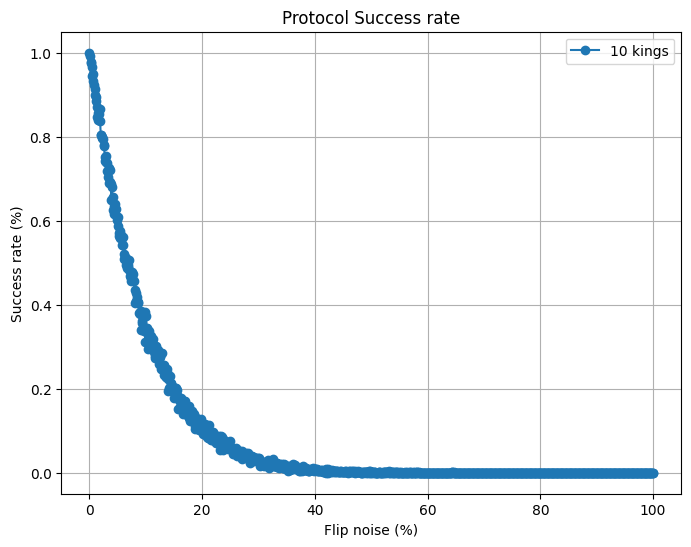

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Function to generate the actual measurement results of the kings
def simulate_kings_measurement(n_kings):
    """
    Randomly generates (s, t) tuples for each king.
      s: 0 or 1 (e.g., Z measurement result; basis information)
      t: 0 or 1 (e.g., X measurement result; used as key bits)
    Returns: [(s1, t1), (s2, t2), ..., (s_n, t_n)]
    """
    outcomes = []
    for _ in range(n_kings):
        s = np.random.choice([0, 1])
        t = np.random.choice([0, 1])
        outcomes.append((s, t))
    return outcomes

# 2. Single trial: Compare actual measurement results and deduced t after applying noise
def run_single_trial_success(n_kings, noise_rate=0.01):
    """
    1. Generates (s, t) results for each king (true outcome).
    2. The kings reveal only the s values, and Alice deduces the t values.
       For each king's t value, assume a bit-flip (0<->1) occurs with a probability of noise_rate.
    3. If all of the deduced t values match the true t values, the trial is a success (success=1);
       if any are different, it is a failure (success=0).
    
    Returns: success (0 or 1)
    """
    # Actual measurement results (true outcomes)
    true_outcomes = simulate_kings_measurement(n_kings)
    true_t = [t for (s, t) in true_outcomes]
    
    # Alice's deduced t: Apply bit-flip with a probability of noise_rate for each t
    deduced_t = []
    for t in true_t:
        if np.random.rand() < noise_rate:
            deduced_t.append(1 - t)
        else:
            deduced_t.append(t)
            
    # Success criteria: if all deduced_t values match true_t, it's a success
    success = int(all(deduced_t[i] == true_t[i] for i in range(n_kings)))
    return success

# 3. Multiple trials simulation (for each noise_rate)
def run_simulation_success(n_trials, n_kings, noise_rate):
    """
    Run n_trials and record the success (0 or 1) of each trial,
    then return the overall success rate (number of successful trials / total trials).
    """
    successes = []
    for _ in range(n_trials):
        s = run_single_trial_success(n_kings, noise_rate)
        successes.append(s)
    successes = np.array(successes)
    success_rate = np.mean(successes)
    return success_rate

# 4. Plot success rate for different noise probabilities
if __name__ == '__main__':
    n_kings = 10         # Example: 8 kings (total 9 qubits including Alice)
    n_trials = 1000     # 1000 trials for each noise probability
    
    # Noise probability range: 0% ~ 10%
    noise_rates = np.linspace(0, 1, 1001) 
    success_rates = []  # Success rates for each noise probability

    for nr in noise_rates:
        rate = run_simulation_success(n_trials, n_kings, noise_rate=nr)
        success_rates.append(rate)
        print(f"Noise: {nr*100:.1f}% -> Success rate: {rate*100:.2f}%")
        
    # Generate plot
    plt.figure(figsize=(8, 6))
    plt.plot(noise_rates * 100, success_rates, marker='o', linestyle='-', label=f"{n_kings} kings")
    plt.xlabel("Flip noise (%)")
    plt.ylabel("Success rate (%)")
    plt.title("Protocol Success rate")
    plt.grid(True)
    plt.legend()
    plt.show()

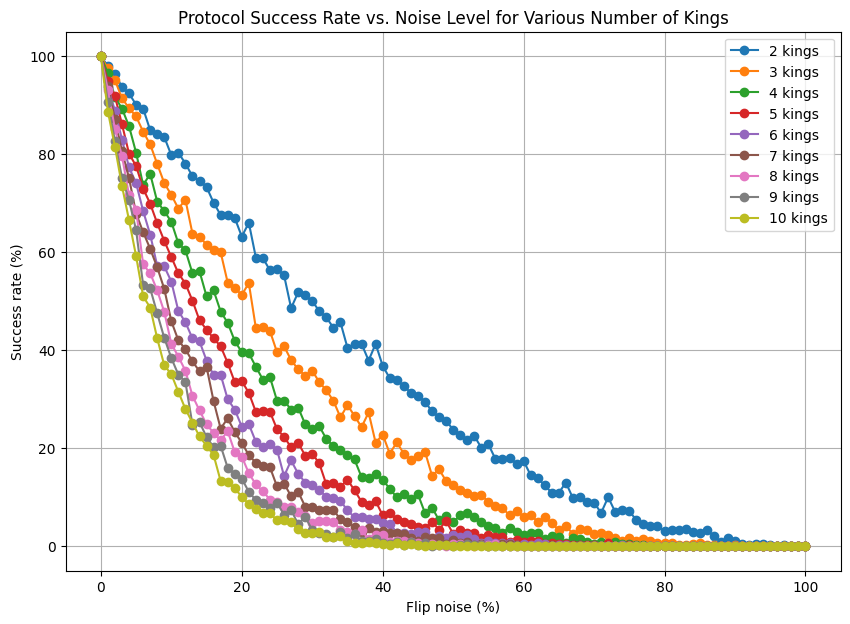

In [13]:
import matplotlib.pyplot as plt

# 1. Function to generate the actual measurement results of the kings
def simulate_kings_measurement(n_kings):
    """
    Randomly generates (s, t) tuples for each king.
      s: 0 or 1 (e.g., Z measurement result; basis information)
      t: 0 or 1 (e.g., X measurement result; used as key bits)
    Returns: [(s1, t1), (s2, t2), ..., (s_n, t_n)]
    """
    outcomes = []
    for _ in range(n_kings):
        s = np.random.choice([0, 1])
        t = np.random.choice([0, 1])
        outcomes.append((s, t))
    return outcomes

# 2. Single trial: Compare actual measurement results and deduced t after applying noise
def run_single_trial_success(n_kings, noise_rate=0.01):
    """
    1. Generates (s, t) results for each king (true outcomes).
    2. The kings reveal only the s values, and Alice deduces the t values.
       Here, it is assumed that a bit-flip occurs with a probability of noise_rate for each king's t.
    3. If all deduced t values match the true t values, the trial is a success (success=1);
       otherwise, it is a failure (success=0).
    
    Returns: success (0 or 1)
    """
    true_outcomes = simulate_kings_measurement(n_kings)
    true_t = [t for (s, t) in true_outcomes]
    
    deduced_t = []
    for t in true_t:
        if np.random.rand() < noise_rate:
            deduced_t.append(1 - t)  # bit-flip
        else:
            deduced_t.append(t)
            
    success = int(all(deduced_t[i] == true_t[i] for i in range(n_kings)))
    return success

# 3. Multiple trials simulation (for each noise probability)
def run_simulation_success(n_trials, n_kings, noise_rate):
    """
    Run n_trials and record the success (0 or 1) of each trial,
    then return the overall success rate (number of successful trials / total trials).
    """
    successes = []
    for _ in range(n_trials):
        s = run_single_trial_success(n_kings, noise_rate)
        successes.append(s)
    return np.mean(successes)

# 4. Generate a plot for various noise probabilities and number of kings
if __name__ == '__main__':
    n_trials = 1000   # Number of trials for each noise probability
    # Noise probability range: 0% ~ 100% (entered as 0~1, displayed as % later)
    noise_rates = np.linspace(0, 1, 101)  # 0%, 1%, ..., 100%
    
    # Simulate for various numbers of kings
    n_kings_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    plt.figure(figsize=(10, 7))
    
    for n_kings in n_kings_list:
        success_rates = []
        for nr in noise_rates:
            rate = run_simulation_success(n_trials, n_kings, noise_rate=nr)
            success_rates.append(rate * 100)  # Convert to percentage
        plt.plot(noise_rates * 100, success_rates, marker='o', linestyle='-', label=f"{n_kings} kings")
    
    plt.xlabel("Flip noise (%)")
    plt.ylabel("Success rate (%)")
    plt.title("Protocol Success Rate vs. Noise Level for Various Number of Kings")
    plt.grid(True)
    plt.legend()
    plt.show()


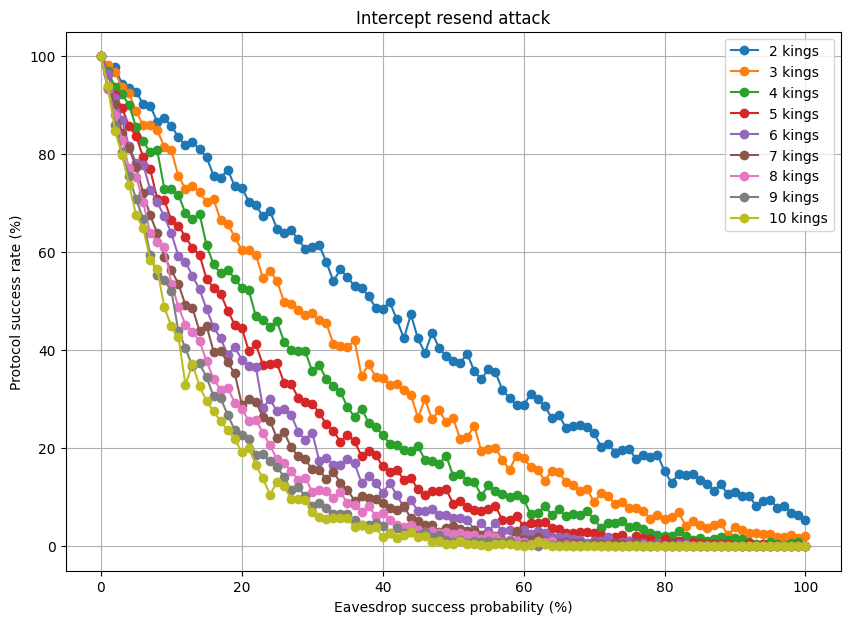

In [14]:
# 1. Function to generate the actual measurement results of the kings
def simulate_kings_measurement(n_kings):
    """
    Randomly generates (s, t) tuples for each king.
      s: 0 or 1 (e.g., basis information)
      t: 0 or 1 (e.g., key bit)
    Returns: [(s1, t1), (s2, t2), ..., (s_n, t_n)]
    """
    outcomes = []
    for _ in range(n_kings):
        s = np.random.choice([0, 1])
        t = np.random.choice([0, 1])
        outcomes.append((s, t))
    return outcomes

# 2. Single trial: Eavesdropper intercept-resend attack
def run_single_trial_eavesdrop(n_kings, intercept_prob):
    """
    After generating the true measurement results (true outcome) for each king,
    the eavesdropper replaces the outcome with a probability intercept_prob.
    
    If the eavesdropper attacks, a new (s, t) pair is chosen completely randomly.
    (That is, the new (s, t) will match the original (s, t) with a probability of 1/4).
    
    A protocol success is defined when all final transmitted outcomes of the kings
    match the actual measurement results.
    
    Returns: success (1 if success, 0 if failure)
    """
    true_outcomes = simulate_kings_measurement(n_kings)
    final_outcomes = []
    for outcome in true_outcomes:
        if np.random.rand() < intercept_prob:
            # Eavesdropper attacks: choose (s, t) completely randomly
            new_s = np.random.choice([0, 1])
            new_t = np.random.choice([0, 1])
            final_outcomes.append((new_s, new_t))
        else:
            # No eavesdropping: send the original outcome
            final_outcomes.append(outcome)
    success = int(all(final_outcomes[i] == true_outcomes[i] for i in range(n_kings)))
    return success

# 3. Multiple trials simulation (for each intercept_prob)
def run_simulation_eavesdrop(n_trials, n_kings, intercept_prob):
    """
    Run n_trials and record the success (0 or 1) of each trial,
    then return the overall success rate (number of successful trials / total trials).
    """
    successes = []
    for _ in range(n_trials):
        s = run_single_trial_eavesdrop(n_kings, intercept_prob)
        successes.append(s)
    return np.mean(successes)

# 4. Generate results plot for various eavesdrop probabilities and number of kings
if __name__ == '__main__':
    n_trials = 1000  # Number of trials for each eavesdrop probability
    # Eavesdrop probability range: 0% ~ 100%
    intercept_probs = np.linspace(0, 1, 101)  # 0, 0.01, ..., 1.0
    
    # Simulate for various numbers of kings
    n_kings_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    plt.figure(figsize=(10, 7))
    
    for n_kings in n_kings_list:
        success_rates = []
        for ip in intercept_probs:
            rate = run_simulation_eavesdrop(n_trials, n_kings, intercept_prob=ip)
            success_rates.append(rate * 100)  # Convert to percentage
        plt.plot(intercept_probs * 100, success_rates, marker='o', linestyle='-', label=f"{n_kings} kings")
    
    plt.xlabel("Eavesdrop success probability (%)")
    plt.ylabel("Protocol success rate (%)")
    plt.title("Intercept resend attack")
    plt.grid(True)
    plt.legend()
    plt.show()

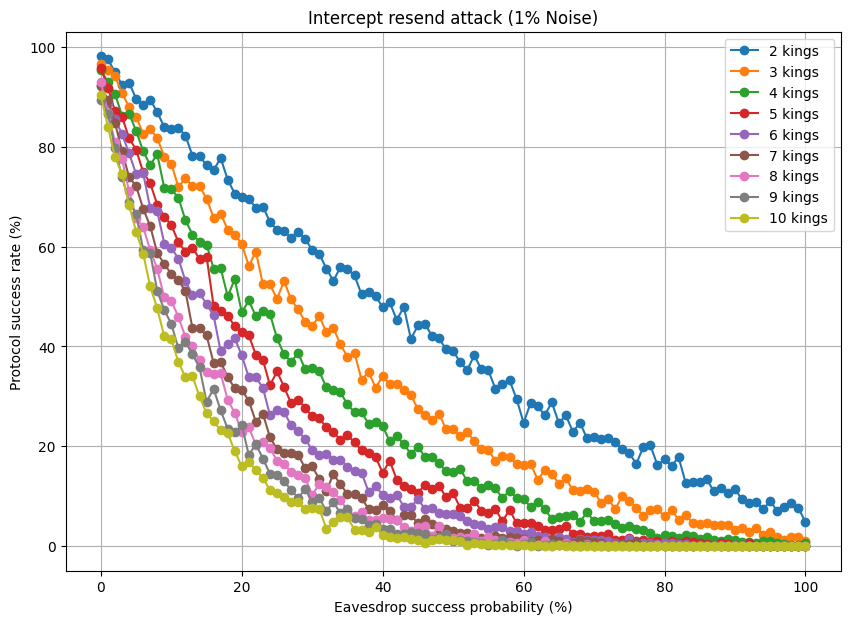

In [15]:
# 1. Function to generate the actual measurement results of the kings
def simulate_kings_measurement(n_kings):
    """
    Randomly generates (s, t) tuples for each king.
      s: 0 or 1 (e.g., basis information)
      t: 0 or 1 (e.g., key bit)
    Returns: [(s1, t1), (s2, t2), ..., (s_n, t_n)]
    """
    outcomes = []
    for _ in range(n_kings):
        s = np.random.choice([0, 1])
        t = np.random.choice([0, 1])
        outcomes.append((s, t))
    return outcomes

# 2. Single trial: Considering both eavesdropping and noise
def run_single_trial_combined(n_kings, intercept_prob, noise_rate):
    """
    After generating the true measurement results (true outcome) for each king,
    apply the following two situations for each king:
    
    - If eavesdropping attack happens (probability intercept_prob):
         The final result = a completely randomly chosen (s, t)
         (In this case, the new (s, t) has a 25% chance of matching the original (s, t)).
    - If no eavesdropping attack happens (probability 1 - intercept_prob):
         Channel noise is applied, and t value is bit-flipped with a probability of noise_rate,
         while s value remains unchanged.
    
    A protocol success is defined when all final transmitted outcomes match the actual measurement results.
    
    Returns: success (1 if success, 0 if failure)
    """
    true_outcomes = simulate_kings_measurement(n_kings)
    final_outcomes = []
    for outcome in true_outcomes:
        if np.random.rand() < intercept_prob:
            # Eavesdropping attack: completely random (s, t)
            new_s = np.random.choice([0, 1])
            new_t = np.random.choice([0, 1])
            final_outcomes.append((new_s, new_t))
        else:
            # No eavesdropping: apply channel noise
            s, t = outcome
            if np.random.rand() < noise_rate:
                t = 1 - t  # t bit-flip
            final_outcomes.append((s, t))
    success = int(all(final_outcomes[i] == true_outcomes[i] for i in range(n_kings)))
    return success

# 3. Multiple trials simulation (for each intercept_prob)
def run_simulation_combined(n_trials, n_kings, intercept_prob, noise_rate):
    """
    Run n_trials and record the success (0 or 1) of each trial,
    then return the overall success rate (number of successful trials / total trials).
    """
    successes = []
    for _ in range(n_trials):
        s = run_single_trial_combined(n_kings, intercept_prob, noise_rate)
        successes.append(s)
    return np.mean(successes)

# 4. Generate results plot for various eavesdrop probabilities (intercept_prob) and number of kings
if __name__ == '__main__':
    n_trials = 1000       # Number of trials for each intercept_prob
    noise_rate = 0.01     # Channel noise: 1%
    
    # Eavesdrop probability range: 0% ~ 100% (from 0 to 1, with 101 points)
    intercept_probs = np.linspace(0, 1, 101)
    
    # Simulate for various numbers of kings (e.g., 4, 6, 8, 10)
    n_kings_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    plt.figure(figsize=(10, 7))
    
    for n_kings in n_kings_list:
        success_rates = []
        for ip in intercept_probs:
            rate = run_simulation_combined(n_trials, n_kings, intercept_prob=ip, noise_rate=noise_rate)
            success_rates.append(rate * 100)  # Convert to percentage
        plt.plot(intercept_probs * 100, success_rates, marker='o', linestyle='-', label=f"{n_kings} kings")
    
    plt.xlabel("Eavesdrop success probability (%)")
    plt.ylabel("Protocol success rate (%)")
    plt.title("Intercept resend attack (1% Noise)")
    plt.grid(True)
    plt.legend()
    plt.show()

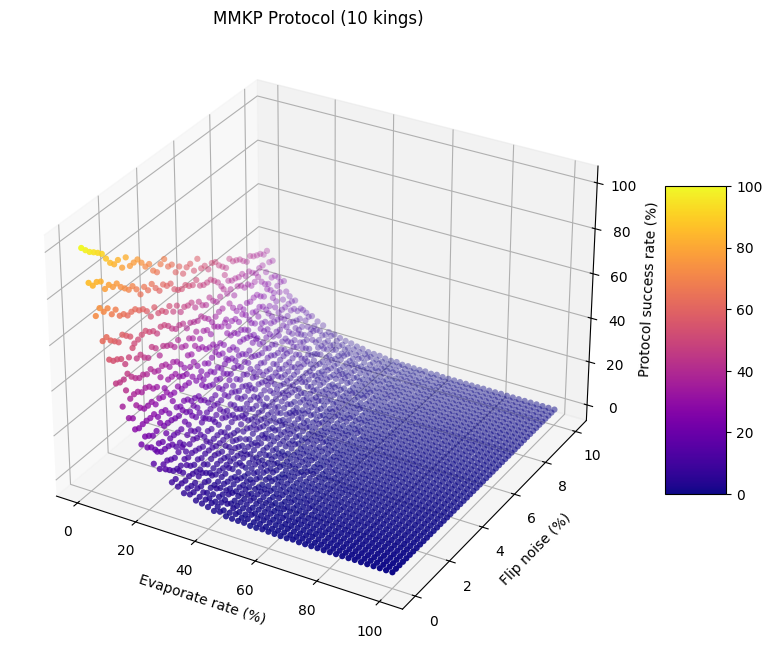

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# 1. Function to generate the actual measurement results of each king with a fixed s value
def simulate_kings_measurement_fixed(n_kings, fixed_s=1):
    """
    Fix the s value for each king at fixed_s (here, 1),
    while randomly generating t values as 0 or 1.
    Returns: [(fixed_s, t1), (fixed_s, t2), ..., (fixed_s, t_n)]
    """
    outcomes = []
    for _ in range(n_kings):
        t = np.random.choice([0, 1])
        outcomes.append((fixed_s, t))
    return outcomes

# 2. Single trial: Considering both channel noise and eavesdropping attack (with fixed s)
def run_single_trial_combined_fixed(n_kings, intercept_prob, noise_rate, fixed_s=1):
    """
    1. Generate the true measurement results for each king with a fixed s=fixed_s.
    2. Apply the following two situations for each king:
         - Eavesdropping attack occurs (with probability intercept_prob): The final result is a randomly chosen (s, t)
           (In this case, the newly chosen (s, t) has a 25% chance of matching the original result).
         - No eavesdropping attack (with probability 1 - intercept_prob): Channel noise is applied,
           s remains fixed_s, and t is bit-flipped with a probability of noise_rate.
    3. If the final transmitted outcomes match the true outcomes for all kings, it is considered a success (success=1);
       otherwise, it is considered a failure (success=0).
    """
    true_outcomes = simulate_kings_measurement_fixed(n_kings, fixed_s)
    final_outcomes = []
    for outcome in true_outcomes:
        if np.random.rand() < intercept_prob:
            # Eavesdropping attack: Choose (s, t) randomly
            new_s = np.random.choice([0, 1])
            new_t = np.random.choice([0, 1])
            final_outcomes.append((new_s, new_t))
        else:
            # No eavesdropping attack: Apply channel noise (bit-flip on t)
            s, t = outcome
            if np.random.rand() < noise_rate:
                t = 1 - t
            final_outcomes.append((s, t))
    success = int(all(final_outcomes[i] == true_outcomes[i] for i in range(n_kings)))
    return success

# 3. Multiple trials simulation: For the given intercept_prob and noise_rate
def run_simulation_combined_fixed(n_trials, n_kings, intercept_prob, noise_rate, fixed_s=1):
    """
    Run n_trials single trials and record the success (0 or 1) for each trial,
    then return the overall success rate (the ratio of successful trials).
    """
    successes = []
    for _ in range(n_trials):
        s = run_single_trial_combined_fixed(n_kings, intercept_prob, noise_rate, fixed_s)
        successes.append(s)
    return np.mean(successes)

# 4. 3D Plot: Success rate when varying intercept_prob and noise_rate (including scatter)
if __name__ == '__main__':
    n_kings = 10       # Example: 10 kings (11 qubits including Alice)
    n_trials = 1000    # Number of trials for each (intercept_prob, noise_rate) combination
    fixed_s = 1        # Fixed s value for all kings
    
    # intercept_prob range: 0 ~ 1 (0% ~ 100%)
    intercept_probs = np.linspace(0, 1, 51)  # Example: 51 points
    # noise_rate range: 0 ~ 0.1 (0% ~ 10%)
    noise_rates = np.linspace(0, 0.1, 51)
    
    # Create a 2D array to store the results: rows - intercept_prob, columns - noise_rate
    success_rates = np.zeros((len(intercept_probs), len(noise_rates)))
    
    for i, ip in enumerate(intercept_probs):
        for j, nr in enumerate(noise_rates):
            rate = run_simulation_combined_fixed(n_trials, n_kings, intercept_prob=ip, noise_rate=nr, fixed_s=fixed_s)
            success_rates[i, j] = rate * 100  # Convert to percentage
    
    # Generate 3D plot
    X, Y = np.meshgrid(intercept_probs * 100, noise_rates * 100)  # X: intercept_prob(%), Y: noise_rate(%)
    Z = success_rates.T  # Transpose to match meshgrid matrix shape
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.scatter(X, Y, Z, c=Z, cmap='plasma', edgecolor='none')
    
    ax.set_xlabel("Evaporate rate (%)")
    ax.set_ylabel("Flip noise (%)")
    ax.set_zlabel("Protocol success rate (%)")
    ax.set_title("MMKP Protocol (10 kings)")
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()